In [66]:
import pandas as pd
from darts import TimeSeries
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)

    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)


# temporary
# X_train["hour"] = X_train.index.hour
# X_train["weekday"] = X_train.index.weekday
# X_train["month"] = X_train.index.month
# X_train["year"] = X_train.index.year

# X_test["hour"] = X_test.index.hour
# X_test["weekday"] = X_test.index.weekday
# X_test["month"] = X_test.index.month
# X_test["year"] = X_test.index.year

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

Processing location A...
Processing location B...
Processing location C...


In [67]:
# auto.dataset_overview(train_data=X_train[X_train["location"]=="B"], test_data=X_test[X_test["location"]=="B"], label="y", sample=None)

# Starting

In [68]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 77
Now creating submission number: 78
New filename: submission_78_jorge


In [69]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'



Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 93024 -> 93024


In [70]:
predictors = [None, None, None]

In [71]:
loc = "A"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[0] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_78_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   34.50 GB / 494.38 GB (7.0%)
Train Data Rows:    34085
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 630.59471, 1165.90242)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary'

Training model for location A...


		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 1): ['snow_drift:idx']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 1 | ['snow_drift:idx']
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 45 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 43 | ['ab

In [72]:

loc = "B"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[1] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_78_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   33.86 GB / 494.38 GB (6.8%)
Train Data Rows:    32844
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 96.82478, 193.94649)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 

Training model for location B...


	Not enough time to generate out-of-fold predictions for model. Estimated time required was 715.24s compared to 51.82s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 28.95s of the 48.9s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 745.08s compared to 37.6s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 17.56s of the 37.51s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-31.9466	 = Validation score   (-mean_absolute_error)
	16.35s	 = Training   runtime
	32.52s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.84s of the 14.94s of remaining time.
	-31.9466	 = Validation score   (-mean_absolute_error)
	0.0

In [73]:
loc = "C"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[2] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_78_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64


Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   33.67 GB / 494.38 GB (6.8%)
Train Data Rows:    26095
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 77.63106, 165.81688)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5539.9 MB
	Train Data (Original)  Memory Usage: 11.12 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify sp

Training model for location C...


		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 1): ['snow_drift:idx']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 1 | ['snow_drift:idx']
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 45 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 43 | ['ab

# Submit

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 93024 -> 93024
Loaded data from: X_test_raw.csv | Columns = 48 / 48 | Rows = 2160 -> 2160


In [75]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [76]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

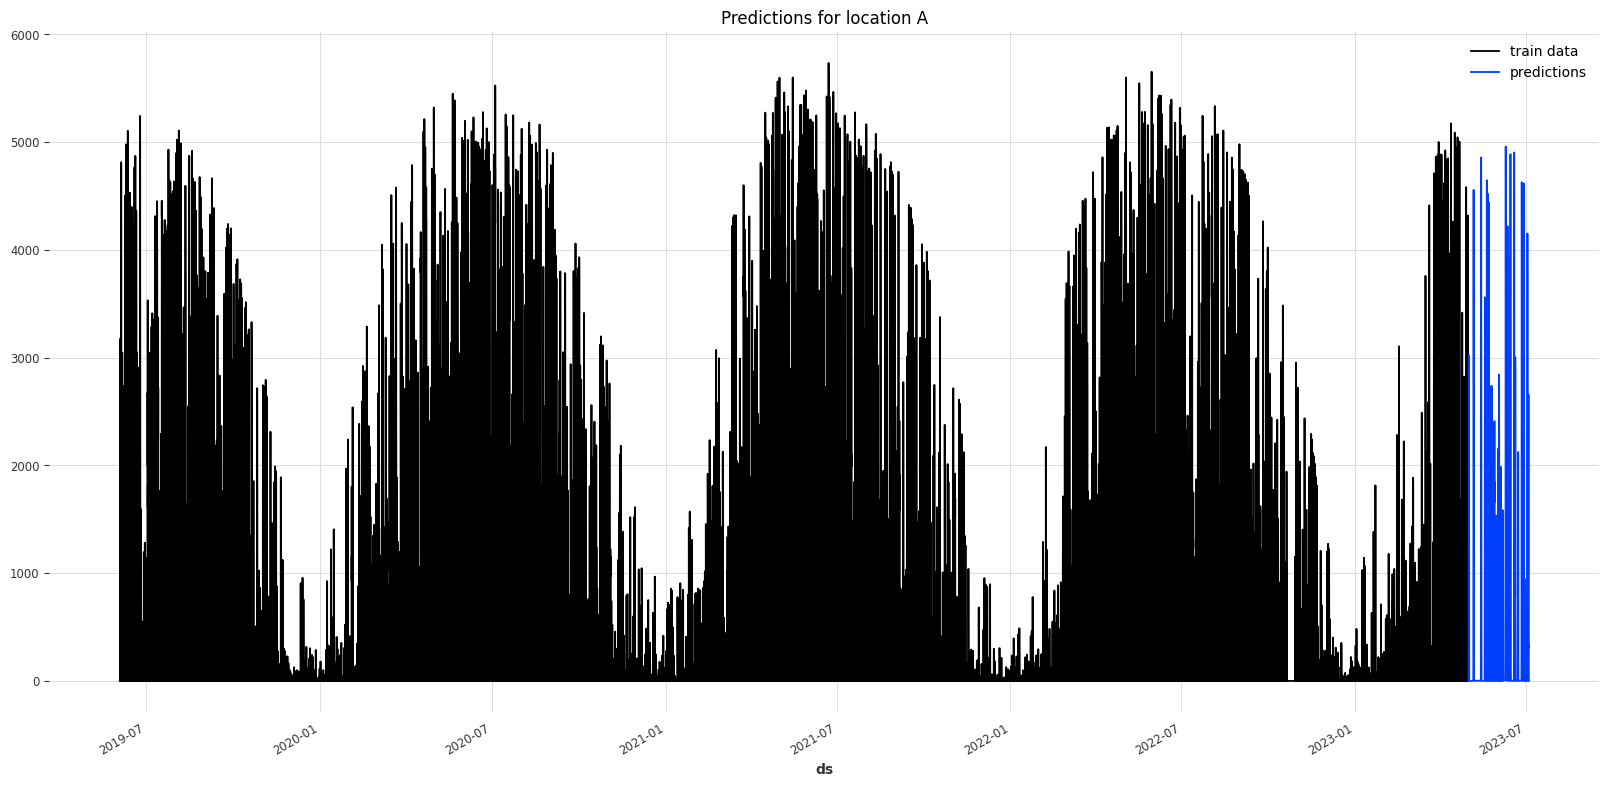

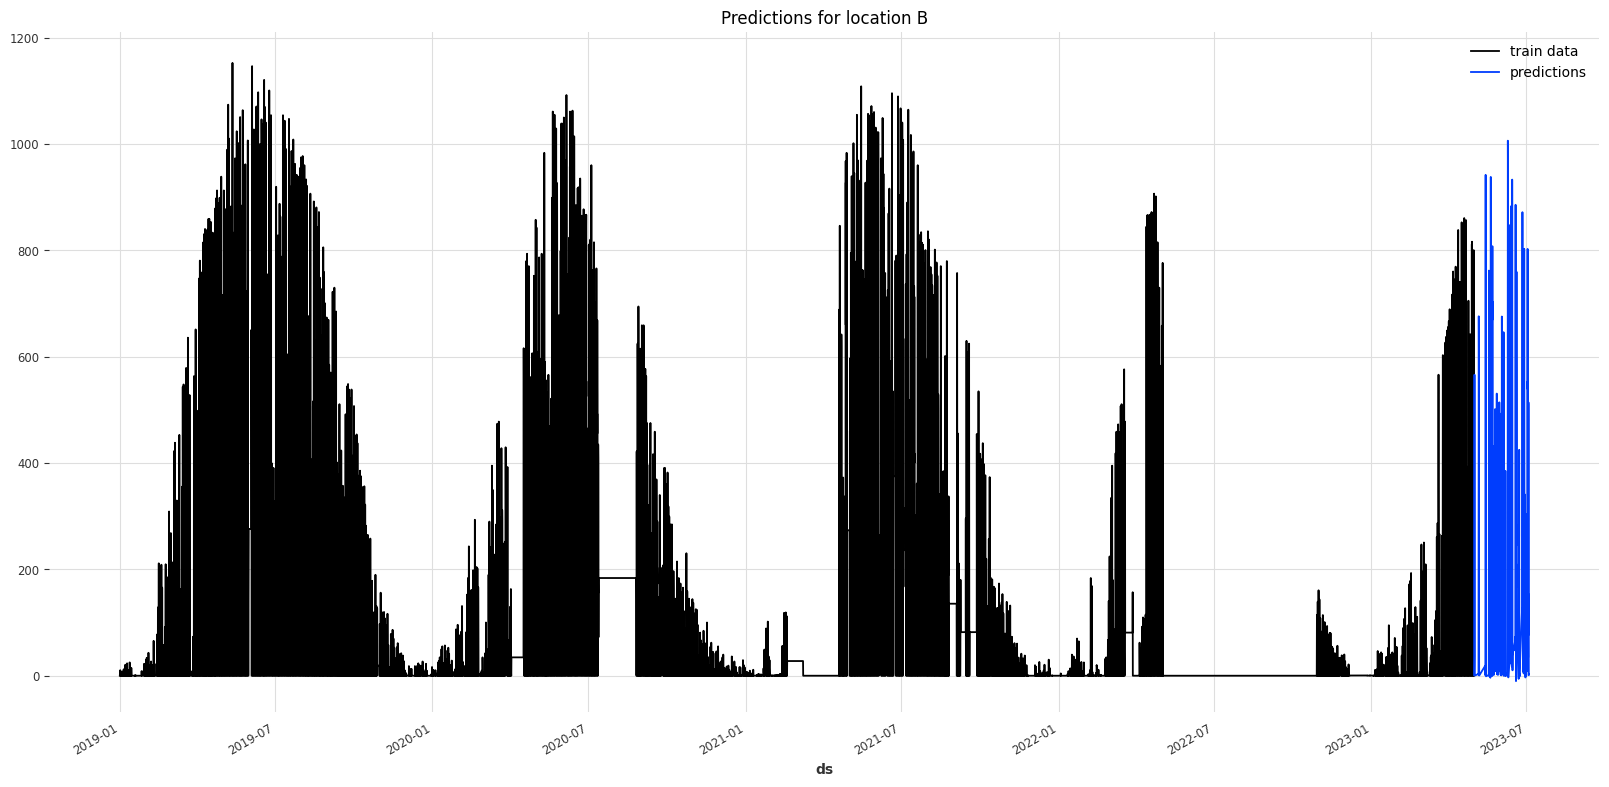

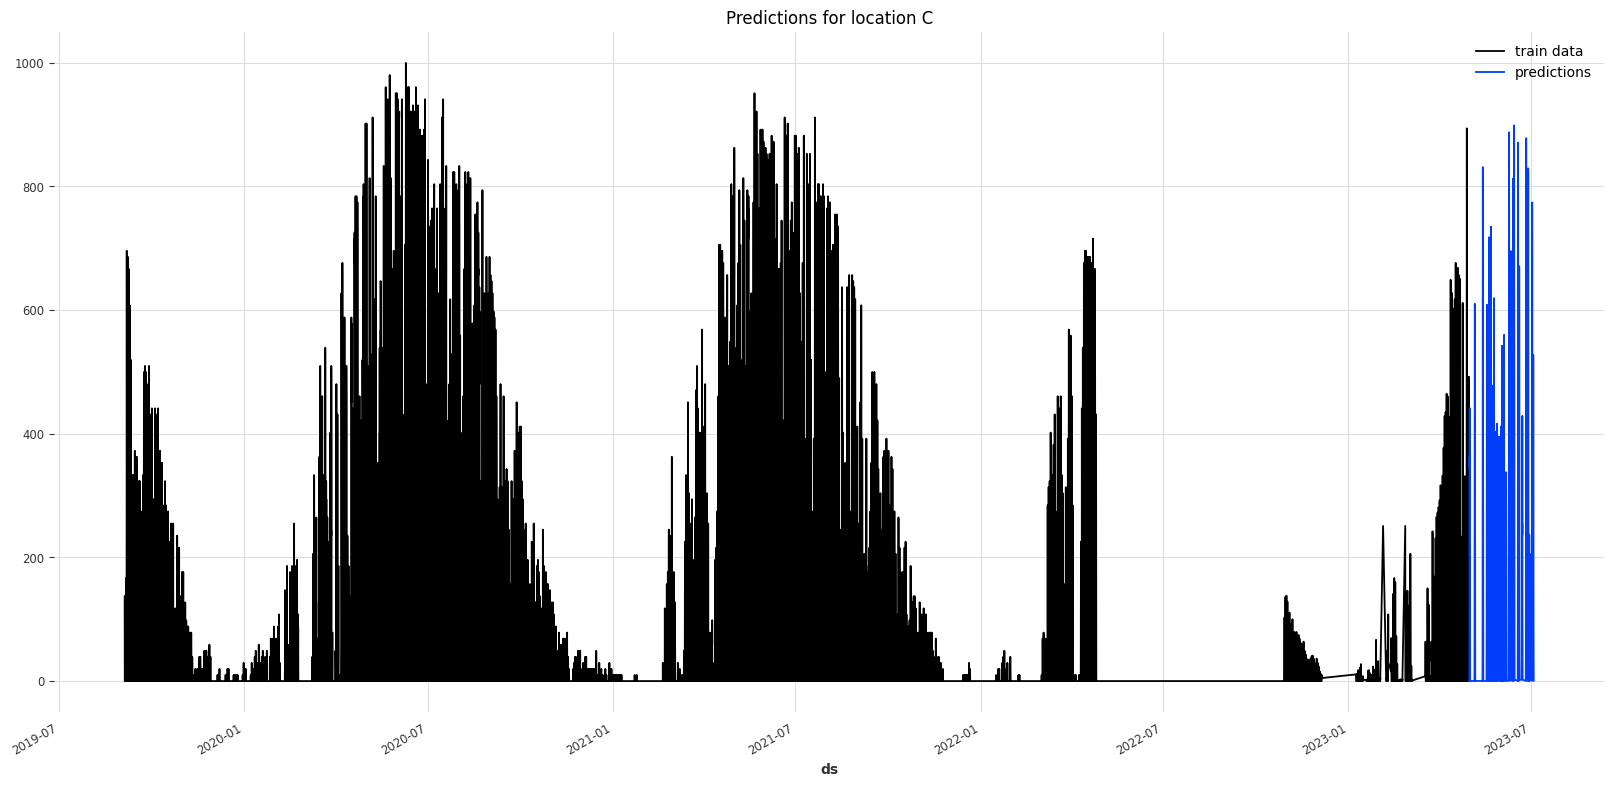

In [77]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [78]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,1.421858
1,1,1.462888
2,2,1.670268
3,3,51.372673
4,4,277.735321
...,...,...
715,2155,94.758957
716,2156,79.856476
717,2157,32.076134
718,2158,4.356977


In [79]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_78_jorge.csv


In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_78_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_78_jorge_files/notebook_pdfs
[NbConvertApp] Writing 76131 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 251165 bytes to notebook_pdfs/submission_78_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_78_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [93]:
# feature importance
predictors[0].feature_importance(feature_stage="original", data=train_data[train_data["location"] == "A"])

These features in provided data are not utilized by the predictor and will be ignored: ['snow_drift:idx', 'location']
Computing feature importance via permutation shuffling for 45 features using 5000 rows with 5 shuffle sets...
	1015.74s	= Expected runtime (203.15s per shuffle set)


In [80]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_78_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_78_jorge_files/notebook_pdfs
[NbConvertApp] Writing 76131 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 251165 bytes to notebook_pdfs/submission_78_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_78_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)